# EOF Analysis of SSTs from 1854 - Present
### Separate modes of natural, interannual variability for i) global ocean and ii) pacific ocean
#### 1.	Eigenvalue spectrum with uncertainty bars
#### 2.	Regression maps for the first several eigenvectors that you think are significant.
#### 3.	Time series of the Principal Components for the first several eigenvectors


In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import scipy.io as sio
from scipy.stats import norm, gamma
import pandas as pd
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from eofs.xarray import Eof
from eofs.examples import example_data_path

%matplotlib inline

In [2]:
# load sst data
fpath = '' # dummy
file_sst = './sst.mnmean.v4.nc'
ds_sst = xr.open_dataset(fpath + file_sst).sel(time=slice('1854','2019')) # skip 1948 and 1949 due to weak data
nlon = len(ds_sst.lon)
nlat = len(ds_sst.lat)
nmonths = len(ds_sst.time)
nyrs = int(len(ds_sst.time)/12)
print(nlat,nlon,nmonths,nyrs)
ds_sst

89 180 1992 166


<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1992)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    history:                 created 10/2014 by CAS using NCDC's ERSST V4 asc...
    title:                   NOAA Extended Reconstructed Sea Surface Temperat...
    climatology:             Climatology is based on 1971-2000 SST, Xue, Y., ...
    description:             In situ data: ICOADS2.5 before 2007 and NCEP in ...
    citation:                Huang et al, 2014: Extended Reconstructed Sea Su...
    comment:                 SSTs were observed by conventional thermometers ...
    Conventions:             CF-1.2
    institution:             This version written at NOAA/ESRL PSD: obtained ...
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    keywords:                Earth Science > Oceans > Ocean Temperature > Sea...
    platform:                Ship and Buoy SSTs from ICOADS R2.5 and NCEP GTS
    instrument:              Conventional thermometers
    source:                  ICOADS R2.5 SST, NCEP GTS SST, HadISST ice, NCEP...
    source_comment:          SSTs were observed by conventional thermometers ...
    geospatial_lon_min:      -1.0
    geospatial_lon_max:      359.0
    geospatial_laty_max:     89.0
    geospatial_laty_min:     -89.0
    geospatial_lat_max:      89.0
    geospatial_lat_min:      -89.0
    geospatial_lat_units:    degrees_north
    geospatial_lon_units:    degrees_east
    cdm_data_type:           Grid
    project:                 NOAA Extended Reconstructed Sea Surface Temperat...
    license:                 No constraints on data access or use
    original_publisher_url:  http://www.ncdc.noaa.gov
    dataset_title:           Extended Reconstructed Sea Surface Temperature (...
    Source:                  http://www.ncdc.noaa.gov/data-access/marineocean...
    References:              http://www.esrl.noaa.gov/psd/data/gridded/data.n...
    data_modified:           2020-02-03

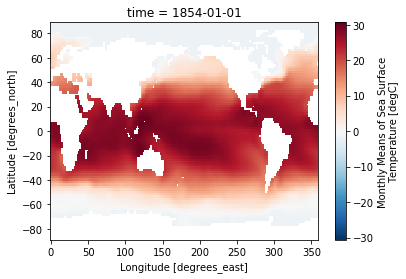

In [3]:
ds_sst.isel(time=0).sst.plot()

In [4]:
## CHOOSE WHICH REGION TO ANALYZE HERE


xlat = [15,-15] # Tropical Ocean
#xlat = [64,-64] # Global SST

# xlon = [0,280] # Tropical Ocean
# xlon = [0,358] # Global adjusted from dennis 1, 357; unclear why he excluded values

# PDO region
# xlat = [65,20]
# xlon = [120,260]

## Remove global mean at each time step

In [5]:
# calculate weights for every grid cell
# assume that these weights are the area of each grid cell (adjusted using cosine of lat)
# because longitudes are equally spaced, we can treat them as length = 1
# so we essentially have rectangular areas between 0 (at pole) and 1 (at equator)

cs = np.cos(np.deg2rad(ds_sst.lat.values)) # cosine weighting by latitude
wts_temp = np.ones(nlat*nlon).reshape(nlat,nlon) # create grid
for i in range(0,nlon):
    wts_temp[:,i] = cs # fill grid with latitude weights

(89, 180)


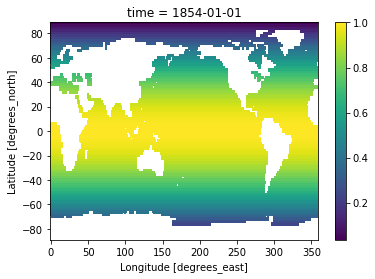

In [6]:
# create land mask of sorts
land = np.isnan(ds_sst.sst.isel(time=0))
wts = xr.DataArray(wts_temp, coords=[ds_sst.lat,ds_sst.lon], dims = ['lat','lon'])
wts = wts.where(land==False)
print(wts.shape)
wts.plot() # weights with NaNs over land

<xarray.DataArray ()>
array(17.91052525)
Coordinates:
    time     datetime64[ns] 1854-01-01


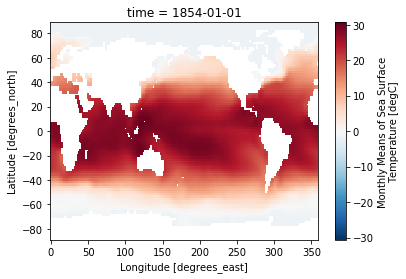

In [7]:
# eyeball check of SSTs to see whether a given weighted mean calc makes sense
print((ds_sst.isel(time=0).sst*wts).sum() / (wts.sum())) # sample weighted mean
ds_sst.isel(time=0).sst.plot()

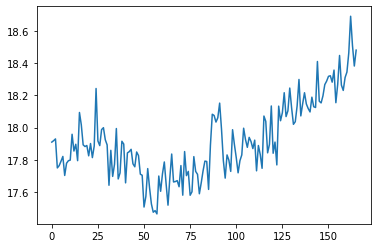

In [8]:
# TESTING MEAN REMOVAL WITH JUST JANUARY -- NOT USED FURTHER
# Get January
sst_01 = ds_sst.sst[0::12,:,:]

# create time series of january global means
gmean_01 = np.zeros(nyrs)

for i in range(0,len(gmean_01)):
    gmean_01[i] = (sst_01[i,:,:]*wts).sum()/(wts.sum())

plt.plot(gmean_01)

In [9]:
# create data array with global mean removed from january
sst_adj_01 = sst_01.copy()

for i in range(0,nyrs):
    sst_adj_01[i,:,:] = sst_adj_01[i,:,:] - gmean_01[i]

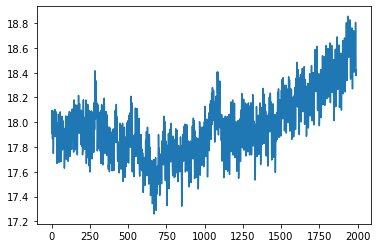

In [10]:
## ALL MONTHS -- THIS CODE IS USED
# create time series of global means
gmean = np.zeros(nmonths)

for i,m in enumerate(gmean):
    gmean[i] = (ds_sst.sst[i,:,:]*wts).sum()/(wts.sum())

plt.plot(gmean)

In [11]:
# create xarray with global mean removed from every month
sst_adj = ds_sst.sst.copy()

for i,temp in enumerate(sst_adj):
    sst_adj[i,:,:] = sst_adj[i,:,:] - gmean[i]
    
# check that mean is zero
print((sst_adj[100,:,:]*wts).sum()/(wts.sum()))

<xarray.DataArray ()>
array(-7.95890477e-07)
Coordinates:
    time     datetime64[ns] 1854-01-01


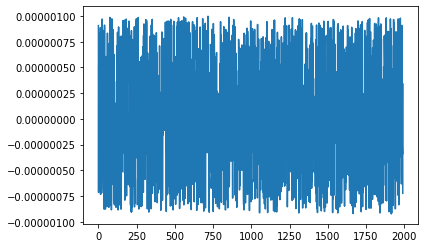

In [12]:
## TRAVIS CHECK THAT EVERYTHING IS ZERO
# create time series of global means
testmean = np.zeros(nmonths)

for i,m in enumerate(testmean):
    testmean[i] = (sst_adj[i,:,:]*wts).sum()/(wts.sum())

plt.plot(testmean)

## Remove climatological mean at each grid point

In [13]:
# create monthly climatology at each grid point
sst_adj_m = sst_adj.groupby('time.month',squeeze=False).mean(dim='time')
sst_adj_m

/glade/u/home/vcooper/miniconda3/envs/xesmfenv/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)>
array([[[-19.719055, -19.719055, -19.719114, ..., -19.719296,
         -19.719055, -19.718994],
        [-19.717546, -19.717365, -19.717125, ..., -19.718994,
         -19.718693, -19.718512],
        [-19.717186, -19.716885, -19.715921, ..., -19.718512,
         -19.71791 , -19.717127],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-19.84801 , -19.84843 , -19.84843 , ..., -19.84807 ,
         -19.847948, -19.847948],
        [-19.84313 , -19.841562, -19.84084 , ..., -19.846622,
         -19.84554 , -19.843853],
        [-19.84307 , -19.841923, -19.840477, ..., -19.846745,
         -19.84566 , -19.844696],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-19.888775, -19.887932, -19.88775 , ..., -19.888775,
         -19.888775, -19.888775],
        [-19.882692, -19.882992, -19.882149, ..., -19.887028,
         -19.88528 , -19.883896],
        [-19.881365, -19.878836, -19.876184, ..., -19.886305,
         -19.884918, -19.88221 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       ...,

       [[-19.688665, -19.688906, -19.688725, ..., -19.688786,
         -19.687822, -19.687822],
        [-19.691736, -19.691496, -19.691315, ..., -19.6921  ,
         -19.69198 , -19.691797],
        [-19.689386, -19.690111, -19.689629, ..., -19.689508,
         -19.689327, -19.689386],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-19.575134, -19.574593, -19.574171, ..., -19.577845,
         -19.57664 , -19.575737],
        [-19.574411, -19.573387, -19.572605, ..., -19.577423,
         -19.576038, -19.575014],
        [-19.573446, -19.571339, -19.56917 , ..., -19.578386,
         -19.576942, -19.574833],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-19.600956, -19.600414, -19.600113, ..., -19.603487,
         -19.602402, -19.6015  ],
        [-19.600174, -19.59921 , -19.598488, ..., -19.603487,
         -19.60222 , -19.601019],
        [-19.598007, -19.596922, -19.596079, ..., -19.602945,
         -19.600655, -19.598732],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [14]:
# remove monthly mean from each grid point
# this gives us only the anomalies controlling for both:
# global trend (area weighted) and seasonality (monthly mean at each grid point)
for i,temp in enumerate(sst_adj):
    m = temp.time.dt.month.values
    sst_adj[i,:,:] = sst_adj[i,:,:] - sst_adj_m.sel(month=m)
sst_adj

<xarray.DataArray 'sst' (time: 1992, lat: 89, lon: 180)>
array([[[ 0.00853157,  0.00853157,  0.0085907 , ...,  0.0087719 ,
          0.00853157,  0.00847054],
        [ 0.00702286,  0.00684166,  0.00660133, ...,  0.00847054,
          0.00816917,  0.00798798],
        [ 0.00666237,  0.00636101,  0.0053978 , ...,  0.00798798,
          0.00738716,  0.00660324],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.02938271,  0.02980423,  0.02980423, ...,  0.02944374,
          0.02932167,  0.02932167],
        [ 0.02450371,  0.02293587,  0.02221298, ...,  0.02799606,
          0.02691269,  0.02522659],
        [ 0.02444267,  0.02329636,  0.02185059, ...,  0.02811813,
          0.02703285,  0.02606964],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.00653076, -0.00737381, -0.00755501, ..., -0.00653076,
         -0.00653076, -0.00653076],
        [-0.0126133 , -0.01231384, -0.01315689, ..., -0.00827789,
         -0.01002502, -0.01140976],
        [-0.01394081, -0.01646996, -0.01912117, ..., -0.00900078,
         -0.01038742, -0.01309586],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       ...,

       [[-0.5707264 , -0.57048607, -0.57066727, ..., -0.57060623,
         -0.57156944, -0.57156944],
        [-0.56765556, -0.5678959 , -0.5680771 , ..., -0.56729126,
         -0.5674114 , -0.5675945 ],
        [-0.5700054 , -0.5692806 , -0.5697632 , ..., -0.56988335,
         -0.57006454, -0.5700054 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.60071373, -0.6012554 , -0.60167694, ..., -0.5980034 ,
         -0.59920883, -0.600111  ],
        [-0.6014366 , -0.60246086, -0.6032429 , ..., -0.5984249 ,
         -0.5898094 , -0.6008339 ],
        [-0.60240173, -0.60450935, -0.606678  , ..., -0.5974617 ,
         -0.59890556, -0.6010151 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.6195431 , -0.62008476, -0.6203861 , ..., -0.617012  ,
         -0.6180973 , -0.6189995 ],
        [-0.6203251 , -0.6212883 , -0.6220112 , ..., -0.617012  ,
         -0.6182785 , -0.61948013],
        [-0.62249184, -0.6235771 , -0.62442017, ..., -0.6175537 ,
         -0.61984444, -0.62176704],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352

In [15]:
# check whether still mean zero
print((sst_adj[101,:,:]*wts).sum()/(wts.sum()))

<xarray.DataArray ()>
array(5.52969055e-07)
Coordinates:
    time     datetime64[ns] 1854-01-01


## EOF Analysis of mean-removed SSTs

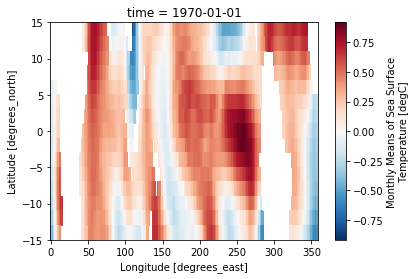

In [16]:
# Check region selected
sst_adj.sel(time=0,lat=slice(xlat[0],xlat[1])).plot()

In [17]:
data = sst_adj.sel(lat=slice(xlat[0],xlat[1]))
data

<xarray.DataArray 'sst' (time: 1992, lat: 15, lon: 180)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.9069662 ,  1.0890756 ,  1.2114849 , ...,  0.27479553,
          0.48214674,  0.69154215],
        [ 0.7600393 ,  0.92545986,  1.0484123 , ...,  0.2443757 ,
          0.38895416,  0.5711818 ],
        [ 0.5675683 ,  0.70973635,  0.81365395, ...,  0.17317057,
          0.27509832,  0.4189558 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.79528093,  0.7966671 ,  0.6995611 , ...,  0.43413973,
          0.59660816,  0.7214284 ],
        [ 0.84625006,  0.8308244 ,  0.72365904, ...,  0.5443826 ,
          0.6832981 ,  0.7938385 ],
        [ 0.8404646 ,  0.8146248 ,  0.702333  , ...,  0.6019702 ,
          0.70636654,  0.8011308 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.4588375 ,  1.5591984 ,  1.4767895 , ...,  0.5391407 ,
          0.8864279 ,  1.2214899 ],
        [ 1.3123341 ,  1.4034767 ,  1.3088956 , ...,  0.46287727,
          0.77040195,  1.0806456 ],
        [ 1.0992594 ,  1.1725111 ,  1.0884776 , ...,  0.3602252 ,
          0.6269722 ,  0.89480066]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.17679954,  0.26589704,  0.33619666, ..., -0.16205549,
         -0.05723619,  0.06680107],
        [ 0.1574626 ,  0.25083637,  0.32481122, ..., -0.23139262,
         -0.08542919,  0.04776406],
        [ 0.12258363,  0.21101642,  0.2811979 , ..., -0.2653668 ,
         -0.12108994,  0.01969051]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.44959116,  0.7421212 ,  1.0725412 , ..., -0.08601236,
          0.02983093,  0.21688032],
        [ 0.38441014,  0.6779642 ,  1.0068188 , ..., -0.16583014,
         -0.02010894,  0.15772176],
        [ 0.31898737,  0.5857959 ,  0.90392804, ..., -0.16757822,
         -0.04300022,  0.1195302 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.9990163 ,  1.1108255 ,  1.2463064 , ...,  0.8005824 ,
          0.85172796,  0.9241376 ],
        [ 1.0161862 ,  1.1443205 ,  1.2995586 , ...,  0.7164273 ,
          0.8170886 ,  0.9127512 ],
        [ 0.9965477 ,  1.1315479 ,  1.301307  , ...,  0.6307044 ,
          0.7638364 ,  0.87817335]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 14.0 12.0 10.0 8.0 6.0 ... -8.0 -10.0 -12.0 -14.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 

In [18]:
# EOF analysis
coslat = np.cos(np.deg2rad(data.coords['lat'].values))
wgts = np.sqrt(coslat)[...,np.newaxis]
solver = Eof(data, weights=wgts)

In [19]:
eof = solver.eofs(neofs=10)
eof_corr = solver.eofsAsCorrelation(neofs=10)
pc = solver.pcs(npcs=10, pcscaling=1)

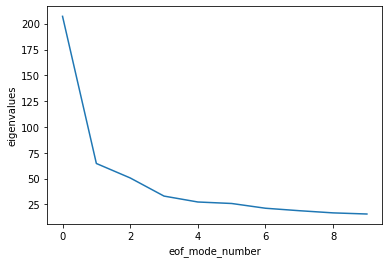

In [20]:
eig = solver.eigenvalues(neigs=10)
varfrac = solver.varianceFraction(neigs=10)
eig.plot()

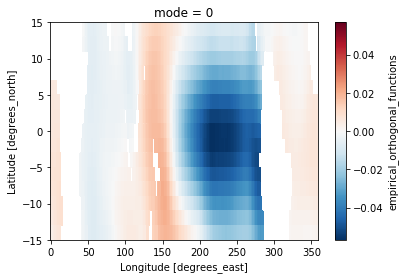

In [21]:
eof[0,:,:].plot()

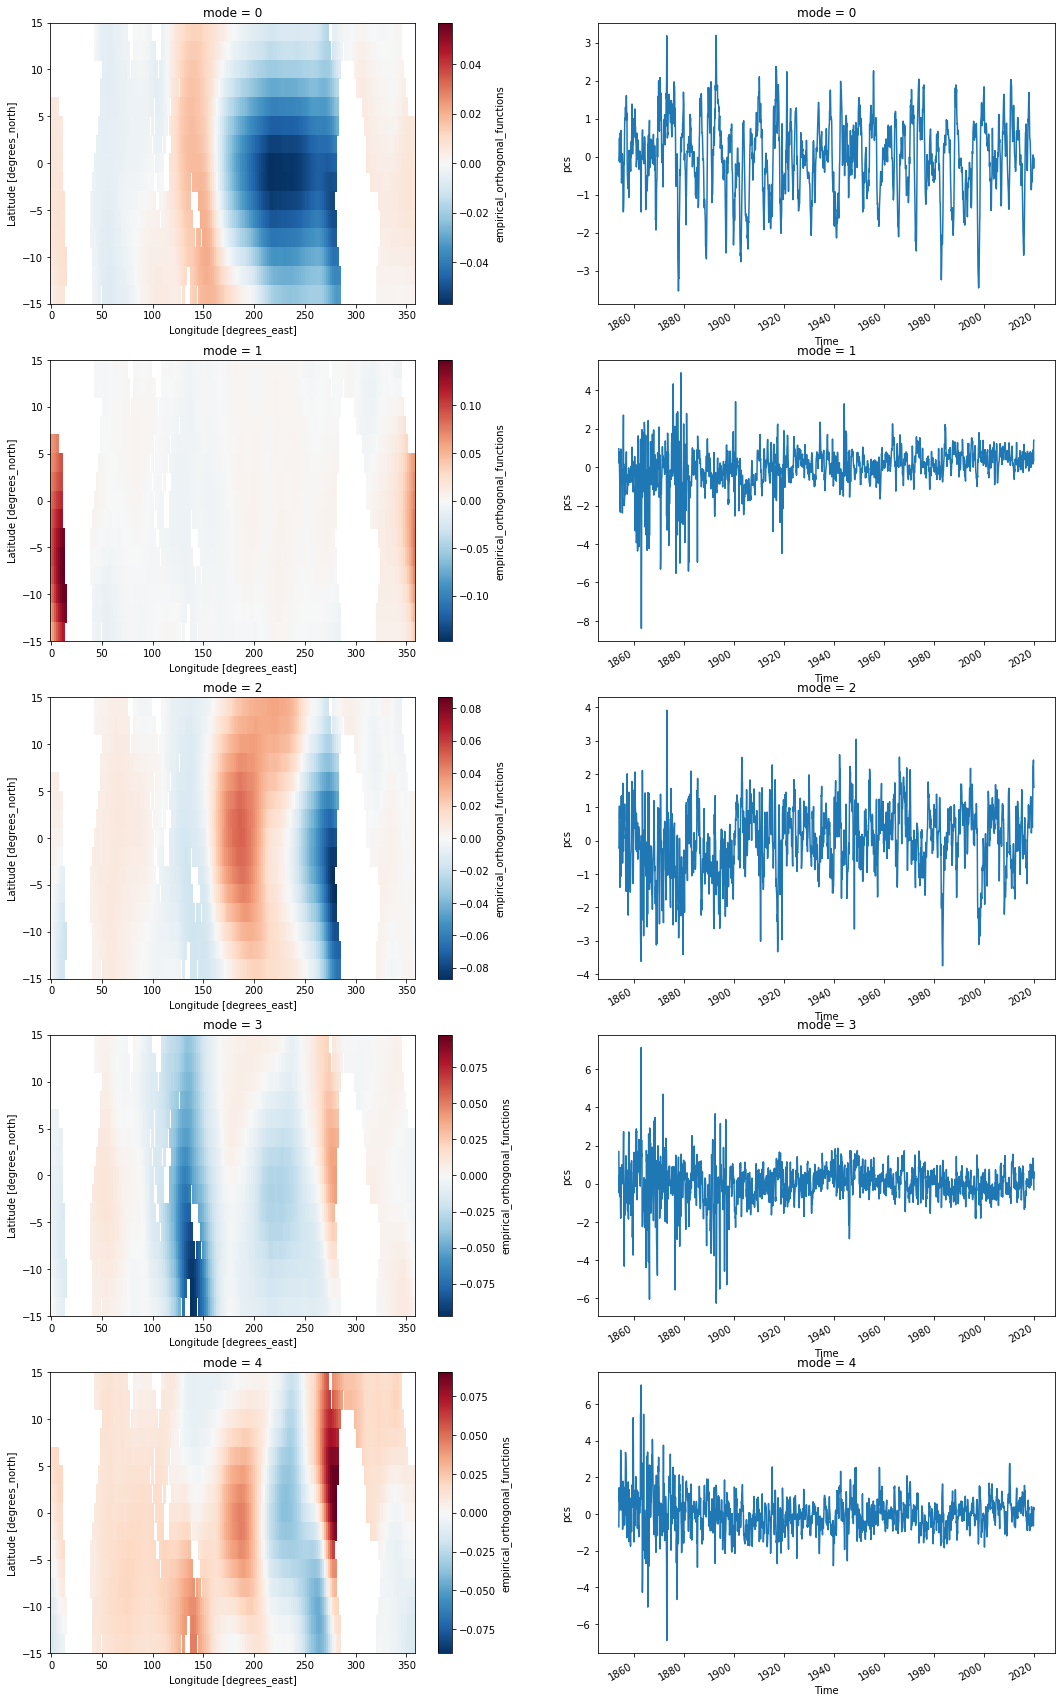

In [22]:
# plot of each EOF and its PC
fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(18,30))
for i in range (0,5):
    eof[i,:,:].plot(ax=ax[i,0])
    pc[:,i].plot(ax=ax[i,1])
    #eof[i,:,:].plot(ax=ax[i,0])

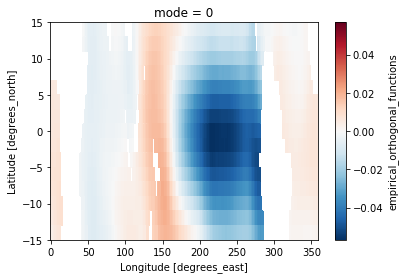

In [23]:
eof[0].plot()

/glade/u/home/vcooper/miniconda3/envs/xesmfenv/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


Text(0.5, 1.0, 'EOF Mode: 4')

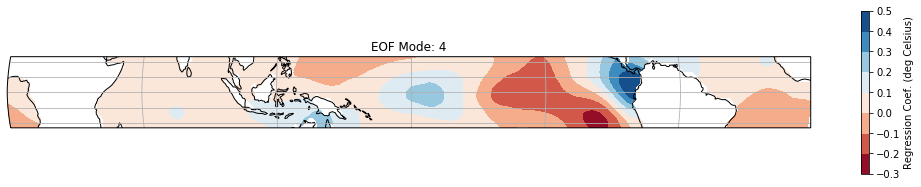

In [62]:
# Regression
fig, ax = plt.subplots(figsize=(18,3))
mode = 4
data = eof[mode]*np.sqrt(eig[mode]) # multiply eof by sq root of eigenvalue to get regression

ax = plt.axes(projection=ccrs.Robinson(180))
#ax.set_extent([0,360,xlat[0],xlat[1]]) # x0,x1,y0,y1
cmap = 'RdBu'
cbar_label = 'Regression Coef. (deg Celsius)'

ax.coastlines()
ax.gridlines()
#plt.title('Test')

#data.plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), cbar_kwargs={"label":cbar_label})
#extra args ds_regress.corr.sel(month=1).plot(ax=ax, vmin=-.8,vmax=0.8,bar_kwargs={'shrink':0.4}, transform=ccrs.PlateCarree())

## contour f detail
contf = ax.contourf(data.lon,data.lat,
            data, 
            cmap=cmap,# levels=levels, hatches=["...",""],
            cbar_kwargs={"label":cbar_label}, 
            transform=ccrs.PlateCarree())
cbar = fig.colorbar(contf)
cbar.ax.set_ylabel(cbar_label)
plt.title('EOF Mode: {0}'.format(mode))

#ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.OCEANS)



Text(0, 0.5, 'PC')

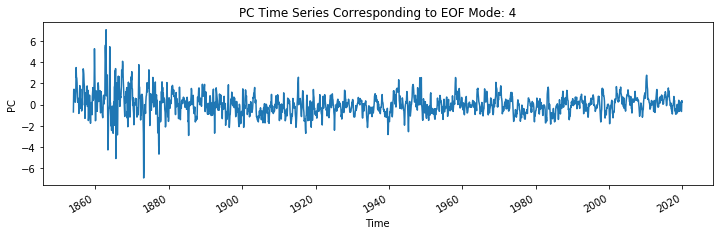

In [63]:
fig, ax = plt.subplots(figsize=(12,3))
pc[:,mode].plot()
plt.title('PC Time Series Corresponding to EOF Mode: {0}'.format(mode))
plt.ylabel('PC')

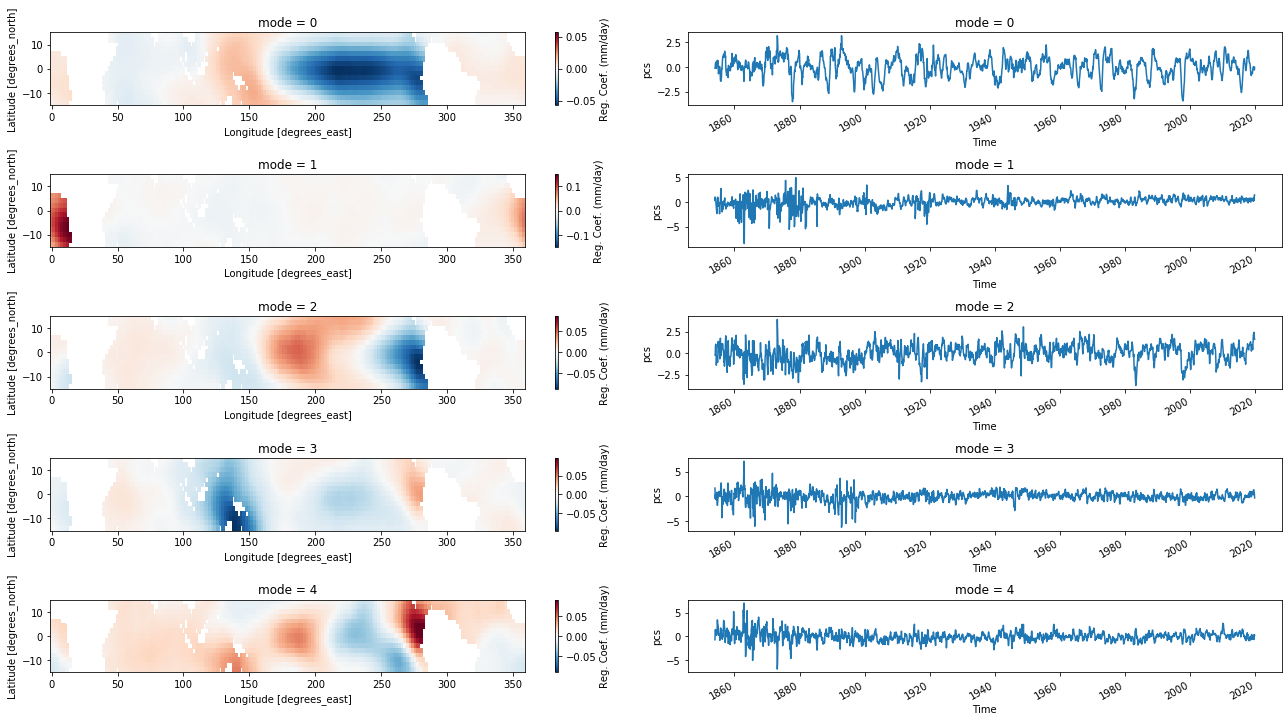

In [26]:
# Individual plots
fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(18,10))
for i in range (0,5):
    eof[i,:,:].plot(ax=ax[i,0], cbar_kwargs={"label":'Reg. Coef. (mm/day)'})
    pc[:,i].plot(ax=ax[i,1])
    #eof[i,:,:].plot(ax=ax[i,0])
    
plt.tight_layout()

In [27]:
pc[:,0::12]#.plot()

<xarray.DataArray 'pcs' (time: 1992, mode: 1)>
array([[-0.10751921],
       [ 0.00405022],
       [ 0.38008302],
       ...,
       [-0.05831796],
       [-0.30961674],
       [-0.04991584]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-12-01
  * mode     (mode) int64 0

#### For testing -- EOFs of unadjusted data

In [28]:
# coslat = np.cos(np.deg2rad(ds_sst.coords['lat'].values))
# wgts = np.sqrt(coslat)[...,np.newaxis]
# solver_orig = Eof(ds_sst.sst, weights=wgts)

In [29]:
# eof5 = solver_orig.eofsAsCorrelation(neofs=5)
# # pc5 = solver_orig.pcs(npcs=5, pcscaling=1)

In [30]:
# eof5[2,:,:].plot()

In [31]:
# eigenvals5 = solver_orig.varianceFraction(neigs=10)

In [32]:
# eigenvals5.plot(marker='o')

## Autocorrelation estimate for degrees of freedom

In [33]:
# looping over all of the lats and lons
# there is surely a more efficient way to do this but i am being careful
# create x as every grid point SST at time t
# y as every grid point SST at time t+1

x = sst_adj[0:len(sst_adj)-1,:,:].values # from t to final t-1
y = sst_adj[1:len(sst_adj),:,:].values # from t+1 to final t
print(x.shape, y.shape, y[0,50,50], x[1,50,50]) # confirming that x is one tstep behind y

corr = np.zeros(nlat*nlon).reshape(nlat,nlon) # lat,lon -- hard code correlation
#reg = np.zeros(nlat*nlon).reshape(nlat,nlon) # lat,lon -- hard code slope

slope = np.zeros(nlat*nlon*2).reshape(nlat,nlon,2)
intercept = np.zeros(nlat*nlon*2).reshape(nlat,nlon,2)
r_value = np.zeros(nlat*nlon*2).reshape(nlat,nlon,2)
p_value = np.zeros(nlat*nlon*2).reshape(nlat,nlon,2)
std_err = np.zeros(nlat*nlon*2).reshape(nlat,nlon,2)

for i in range(0,nlat):
    for j in range(0,nlon):
        slope[i,j,0], intercept[i,j,0], r_value[i,j,0], p_value[i,j,0], std_err[i,j,0] = stats.linregress(x[:,i,j], y[:,i,j])
        #corr[i,j] = np.sum(y[:,i,j]*x[:,i,j])/(yrmx-1) # simplified formula for r bc of normalized vars; N-1 div for unbiased
        #reg[i,j] = corr[i,j]*np.std(y_precip[:,i,j],ddof=1) # transform r to b for regression


(1991, 89, 180) (1991, 89, 180) -0.03579998 -0.03579998


<xarray.DataArray ()>
array(0.74884486)
Coordinates:
    corr     int64 0
    time     datetime64[ns] 1854-01-01


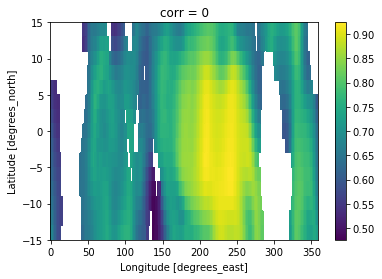

In [34]:
# calculate area-weighted correlation 
r_da = xr.DataArray(r_value, coords=[sst_adj.lat,sst_adj.lon,[0,1]], dims = ['lat','lon','corr'])
r_auto = (r_da.sel(lat=slice(xlat[0],xlat[1]),corr=0)*wts.sel(lat=slice(xlat[0],xlat[1]))).sum()/(wts.sel(lat=slice(xlat[0],xlat[1])).sum()) # area weighted, selected for area of analysis
print(r_auto)
r_da.sel(lat=slice(xlat[0],xlat[1]),corr=0).plot()

In [35]:
# Bretherton 1999 degrees of freedom for autocorrelation estimate
df = nmonths*(1-r_auto**2)/(1+r_auto**2)
df

<xarray.DataArray ()>
array(560.58846926)
Coordinates:
    corr     int64 0
    time     datetime64[ns] 1854-01-01

## Plot eigenvalue spectrum with error bars

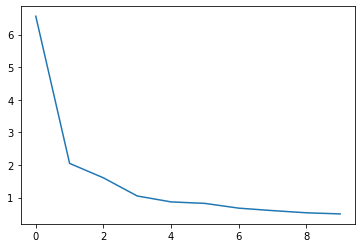

In [36]:
north = solver.northTest(neigs=10)
north_arr = eig*(np.sqrt(2/df)) # North (1982) standard error
plt.plot(north)

Text(0.5, 1.0, 'Eigenvalue Spectrum')

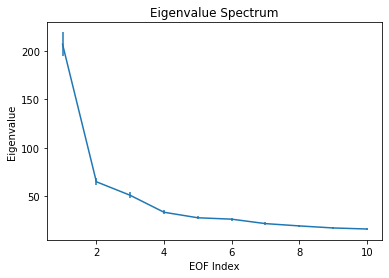

In [37]:
# Plot eigenvalue spectrum with error bars
plt.errorbar(np.arange(1,len(eig)+1),eig,yerr=north_arr,barsabove=True)
plt.ylabel('Eigenvalue')
plt.xlabel('EOF Index')
plt.title('Eigenvalue Spectrum')

In [38]:
north_arr

<xarray.DataArray (mode: 10)>
array([12.37499639,  3.8630643 ,  3.02689251,  1.97735184,  1.63576454,
        1.54912322,  1.27407888,  1.13167907,  1.00569704,  0.94029159])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
    corr     int64 0
    time     datetime64[ns] 1854-01-01

<xarray.DataArray 'variance_fractions' ()>
array(0.54189997)


Text(0.5, 1.0, 'Eigenvalue Spectrum: Variance Explained')

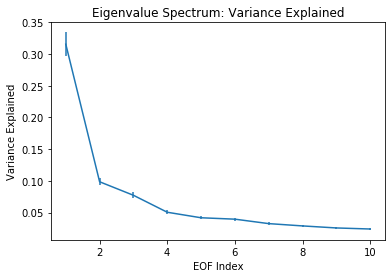

In [39]:
# Plot variance explained with error bars

# scaling uncertainty bars with proportional shortcut, probably is wrong
var_err = (north_arr/eig).mean()*varfrac

print(sum(varfrac[0:4]))
plt.errorbar(np.arange(1,len(eig)+1),varfrac,yerr=var_err,barsabove=True)
plt.ylabel('Variance Explained')
plt.xlabel('EOF Index')
plt.title('Eigenvalue Spectrum: Variance Explained')

## Regression Analysis

In [1]:
df

NameError: name 'df' is not defined

In [41]:
eof[0]

<xarray.DataArray 'eofs' (lat: 15, lon: 180)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00573806, 0.00633226, 0.00685923, ..., 0.00450789, 0.00483424,
        0.00516907],
       [0.0045216 , 0.0051657 , 0.00591606, ..., 0.00320239, 0.00350143,
        0.0039796 ],
       [0.00297089, 0.00373424, 0.00460679, ..., 0.00160373, 0.00188729,
        0.00238285]], dtype=float32)
Coordinates:
    mode     int64 0
  * lat      (lat) float32 14.0 12.0 10.0 8.0 6.0 ... -8.0 -10.0 -12.0 -14.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    long_name:  empirical_orthogonal_functions

In [74]:
# test to check tropical mean of PC1 after specified time
# looks like this is Clausius Clapeyron, slowed warming in tropics
# because global mean is detrended, not tropical mean only
# this captures that tropics are moving slow compared to globe
pc[1500:,1].mean()

<xarray.DataArray 'pcs' ()>
array(0.43029422, dtype=float32)
Coordinates:
    mode     int64 1

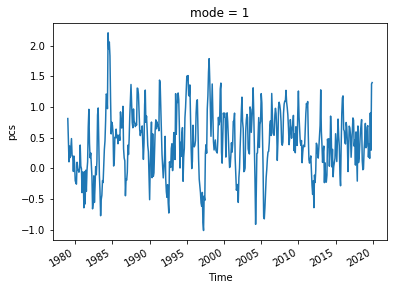

In [73]:
pc[1500:,1].plot()

## Example package

In [42]:
# Read SST anomalies using the xarray module. The file contains November-March
# averages of SST anomaly in the central and northern Pacific.
filename = example_data_path('sst_ndjfm_anom.nc')
sst = xr.open_dataset(filename)['sst']
sst#[0,:,:].plot()

<xarray.DataArray 'sst' (time: 50, latitude: 18, longitude: 30)>
array([[[ 4.318080e-01,           nan, ..., -5.099366e-04, -6.166888e-02],
        [ 3.851656e-02,  1.042517e-01, ..., -1.178146e-01, -1.578676e-01],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       [[ 2.928355e-01,           nan, ..., -3.901250e-01, -5.419934e-01],
        [ 1.990132e-01,  6.390592e-01, ..., -1.983026e-01, -3.549605e-01],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       ...,

       [[ 7.829272e-01,           nan, ..., -1.392927e+00, -1.070007e+00],
        [ 4.601060e-01,  2.474768e-01, ..., -7.000861e-01, -7.082649e-01],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       [[ 5.567895e-01,           nan, ..., -1.788158e-02, -1.602829e-01],
        [ 5.618092e-01,  4.567434e-01, ...,  5.617435e-01,  2.904408e-01],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1963-01-15T12:00:00 ... 2012-01-16
  * latitude   (latitude) float32 -22.5 -17.5 -12.5 -7.5 ... 47.5 52.5 57.5 62.5
  * longitude  (longitude) float32 117.5 122.5 127.5 132.5 ... 252.5 257.5 262.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      NDJFM mean SST anomalies

In [43]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)
coslat

array([0.9238795 , 0.95371693, 0.976296  , 0.9914449 , 0.99904823,
       0.99904823, 0.9914449 , 0.976296  , 0.95371693, 0.9238795 ,
       0.8870108 , 0.8433914 , 0.7933533 , 0.7372773 , 0.67559016,
       0.6087614 , 0.5372996 , 0.4617486 ], dtype=float32)

In [44]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)

Text(0.5, 1.0, 'EOF1 expressed as correlation')

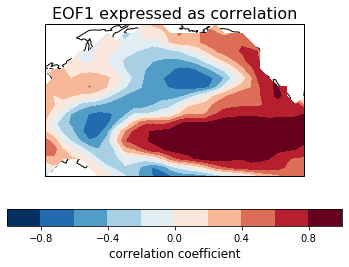

In [45]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)

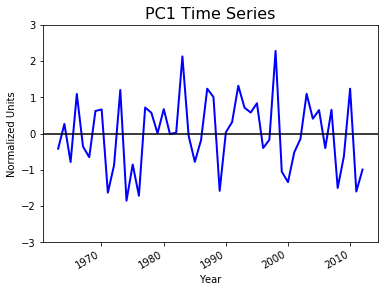

In [46]:
# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

plt.show()